In [1]:
#Install packages for pressure devices
import sys
from email.header import UTF8
sys.path.append('./DLL64')
sys.path.append('./Elveflow64.py')
from ctypes import *
from array import array
from Elveflow64 import *
import time
import matplotlib.pyplot as plt
import numpy as np

Instr_ID = c_int32()

In [2]:
#Input the setup type - Ensure no other instances are running
def pressure_init():
    print("Instrument name and regulator types are hardcoded in the Python script")
    #Insert Machine Code HERE
    error = OB1_Initialization('01EA53FD'.encode('ascii'),2,2,2,2,byref(Instr_ID)) 
    print('error:%d' % error)
    print("OB1 ID: %d" % Instr_ID.value)

pressure_init()

Instrument name and regulator types are hardcoded in the Python script
error:0
OB1 ID: 0


In [3]:
#error=OB1_Add_Sens(Instr_ID, 1, 5, 1, 0, 7, 0)
error=OB1_Add_Sens(Instr_ID, 1, 4, 1, 0, 7, 0) #marcus sensor
#error=OB1_Add_Sens(Instr_ID, 2, 5, 1, 0, 7, 0)
#InstrID, Sensor Type (5-1000ul/min), Analogue(0), Calibration (H20 - 0)
print('error add digit flow sensor:%d' % error)

error add digit flow sensor:0


In [4]:
Calib = (c_double*1000)()
def pressure_calib(answer): # Always define array this way, calibration should have 1000 elements
    while True:
        Calib_path = './Calib.txt'
        if answer == 'default':
            error = Elveflow_Calibration_Default (byref(Calib),1000)
            print("Default Calibration taken")
            break
            
        if answer == 'load':
            error = Elveflow_Calibration_Load (Calib_path.encode('ascii'), byref(Calib), 1000)
            break
            
        if answer == 'new':
            OB1_Calib (Instr_ID.value, Calib, 1000)
            error = Elveflow_Calibration_Save(Calib_path.encode('ascii'), byref(Calib), 1000)
            print('Calib saved in %s' % Calib_path.encode('ascii'))
            break

pressure_calib('default')

Default Calibration taken


In [22]:
def set_pressure(set_channel,set_pressure):
    set_channel=int(set_channel) # convert to int
    set_channel=c_int32(set_channel) # convert to c_int32
    set_pressure=float(set_pressure) 
    set_pressure=c_double(set_pressure) # convert to c_double
    error=OB1_Set_Press(Instr_ID.value, set_channel, set_pressure, byref(Calib),1000) 
    return error 

set_pressure(1,80)

0

In [23]:
def get_pressure_data(press_channel):
    set_channel=c_int32( int(press_channel) ) # convert to c_int32
    get_pressure=c_double()
    error=OB1_Get_Press(Instr_ID.value, set_channel, 1, byref(Calib),byref(get_pressure), 1000) # Acquire_data=1 -> read all the analog values
    return get_pressure.value, error

get_pressure_data(1)

(84.8906678, 0)

In [27]:
def get_sensor_data(sensor_channel):
    data_sens=c_double()
    set_channel=int(sensor_channel) # convert to int
    set_channel=c_int32(sensor_channel) # convert to c_int32
    error=OB1_Get_Sens_Data(Instr_ID.value,set_channel, 1,byref(data_sens)) # Acquire_data=1 -> read all the analog values
    return data_sens.value, error
print(get_sensor_data(1))

(13.133333333333333, 0)


In [8]:
#Constant Pressure

period = 0.5
experiment_t = 120
start_t = time.time()
last_t = start_t
ref_flow = 60
adjustment = 0

tuning_const = 0.08

flow_list, cont_pressure_list, real_pressure_list = [],[],[]

set_pressure(1,60)
pr = get_pressure_data(1)[0]
pr_control = pr

while True:
    fr = get_sensor_data(1)[0]
    flow_list.append(fr)
    print("Flow rate -",fr)
    fr_error = fr-ref_flow
    pr = get_pressure_data(1)[0]  
    real_pressure_list.append(pr)  
    print("Actual P -", pr,"\n----")
    cont_pressure_list.append(pr_control)
    set_pressure(1,pr_control)
    print("Control P -", pr_control)
    if (time.time() - start_t) > experiment_t:
        break
    # Wait until desired period time
    sleep_t = period - (time.time() - last_t)
    if sleep_t > 0:
        time.sleep( sleep_t )
    last_t = time.time() # And update the last time 
    pr_error =  pr - pr_control 


plt.rcParams['axes.grid'] = True
fig=plt.figure()
fig.suptitle("Microfluidic Circuit Control at {0:.2f}Hz".format(1/period))

plt.subplot(2,1,1)
plt.plot( flow_list )
plt.ylabel('flow [uL/min]')
plt.subplot(2,1,2)
plt.plot(cont_pressure_list)
plt.plot(real_pressure_list)
plt.ylabel('pressure [mbar]')

Flow rate - 276.0
Actual P - 54.100024999999995 
----
Control P - 44.7020778
Flow rate - 311.8965517241379
Actual P - 48.473622399999996 
----
Control P - 44.7020778
Flow rate - 317.37931034482756
Actual P - 48.9682512 
----
Control P - 44.7020778
Flow rate - 322.86206896551727
Actual P - 49.4010514 
----
Control P - 44.7020778
Flow rate - 329.9655172413793
Actual P - 49.8956802 
----
Control P - 44.7020778
Flow rate - 334.82758620689657
Actual P - 50.142994599999994 
----
Control P - 44.7020778
Flow rate - 337.62068965517244
Actual P - 50.4521376 
----
Control P - 44.7020778
Flow rate - 340.86206896551727
Actual P - 50.5139662 
----
Control P - 44.7020778
Flow rate - 340.82758620689657
Actual P - 49.9575088 
----
Control P - 44.7020778
Flow rate - 329.7241379310345
Actual P - 49.5247086 
----
Control P - 44.7020778
Flow rate - 328.13793103448273
Actual P - 49.4010514 
----
Control P - 44.7020778
Flow rate - 327.7931034482759
Actual P - 49.46288 
----
Control P - 44.7020778
Flow rate -

KeyboardInterrupt: 

Flow rate - 16.477777777777778
Actual P - 20.8980668 
----
Control P - 21.17146042222222
Flow rate - 16.462962962962962
Actual P - 20.8980668 
----
Control P - 21.50683079259259
Flow rate - 16.492592592592594
Actual P - 20.8362382 
----
Control P - 21.841904866666667
Flow rate - 16.474074074074075
Actual P - 20.8980668 
----
Control P - 22.177164125925927
Flow rate - 18.833333333333332
Actual P - 22.876582 
----
Control P - 22.488830792592594
Flow rate - 23.666666666666668
Actual P - 25.349726 
----
Control P - 22.752164125925926
Flow rate - 31.251851851851853
Actual P - 27.328241199999997 
----
Control P - 22.939645607407407
Flow rate - 31.28148148148148
Actual P - 27.513727 
----
Control P - 23.126830792592592
Flow rate - 31.55925925925926
Actual P - 27.6373842 
----
Control P - 23.3112382
Flow rate - 31.962962962962962
Actual P - 27.822869999999998 
----
Control P - 23.491608570370367
Flow rate - 32.3
Actual P - 28.0701844 
----
Control P - 23.668608570370367
Flow rate - 32.59259259

Text(0, 0.5, 'pressure [mbar]')

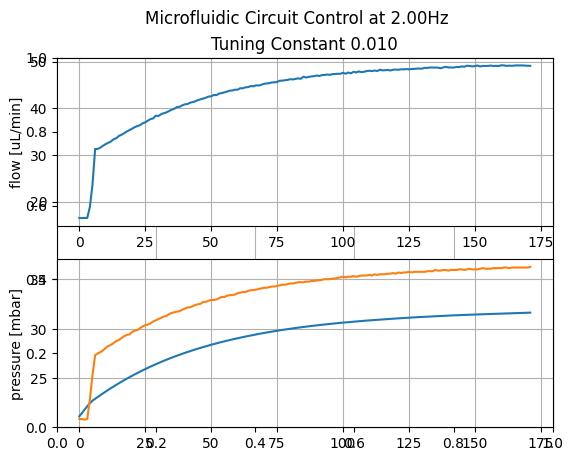

In [29]:
period = 0.5
experiment_t = 90
start_t = time.time()
last_t = start_t
ref_flow = 50
adjustment = 0

tuning_const = 0.01

flow_list, cont_pressure_list, real_pressure_list = [],[],[]

set_pressure(1,5)
pr = get_pressure_data(1)[0]
time.sleep(5)
pr_control = pr

while True:
    fr = get_sensor_data(1)[0]
    flow_list.append(fr)
    print("Flow rate -",fr)
    fr_error = fr-ref_flow
    pr = get_pressure_data(1)[0]  
    real_pressure_list.append(pr)  
    print("Actual P -", pr,"\n----")
    adjustment =  fr_error*tuning_const
    pr_control = pr_control - adjustment 
    cont_pressure_list.append(pr_control)
    set_pressure(1,pr_control)
    print("Control P -", pr_control)
    if (time.time() - start_t) > experiment_t:
        break
    # Wait until desired period time
    sleep_t = period - (time.time() - last_t)
    if sleep_t > 0:
        time.sleep( sleep_t )
    last_t = time.time() # And update the last time 
    pr_error =  pr - pr_control 

set_pressure(1,0)

plt.rcParams['axes.grid'] = True
fig=plt.figure()
fig.suptitle("Microfluidic Circuit Control at {0:.2f}Hz".format(1/period))
plt.title(f"Tuning Constant {tuning_const:.3f}")

plt.subplot(2,1,1)
plt.plot( flow_list )
plt.ylabel('flow [uL/min]')
plt.subplot(2,1,2)
plt.plot(cont_pressure_list)
plt.plot(real_pressure_list)
plt.ylabel('pressure [mbar]')



Text(0, 0.5, 'pressure [mbar]')

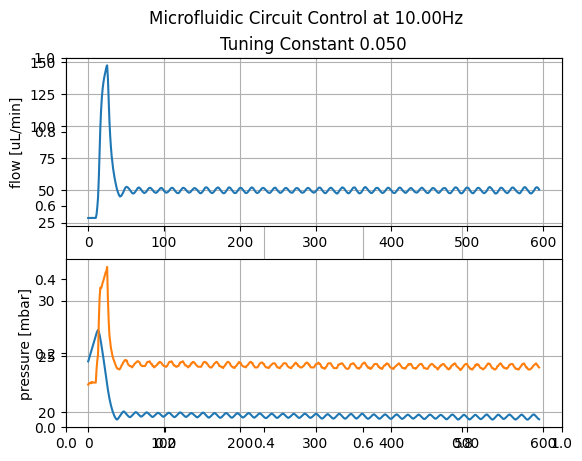

In [31]:
plt.rcParams['axes.grid'] = True
fig=plt.figure()
fig.suptitle("Microfluidic Circuit Control at {0:.2f}Hz".format(1/period))
plt.title(f"Tuning Constant {tuning_const:.3f}")

plt.subplot(2,1,1)
plt.plot( flow_list )
plt.ylabel('flow [uL/min]')
plt.subplot(2,1,2)
plt.plot(cont_pressure_list)
plt.plot(real_pressure_list)
plt.ylabel('pressure [mbar]')

In [45]:

#Input the setup type
def pressure_init():
    print("Instrument name and regulator types are hardcoded in the Python script")
    #Insert Machine Code HERE
    error = OB1_Initialization('COM1'.encode('ascii'),1,1,1,1,byref(Instr_ID)) 
    print('error:%d' % error)
    print("OB1 ID: %d" % Instr_ID.value)

def sensor_init():
    error=OB1_Add_Sens(Instr_ID, 1, 10, 0, 0, 7, 0)
    print('error add digit flow sensor:%d' % error)

def pressure_calib(answer):
    Calib = (c_double*1000)() # Always define array this way, calibration should have 1000 elements
    while True:
        Calib_path = 'C:\\Users\\Public\\Desktop\\Calibration\\Calib.txt'
        if answer == 'default':
            error = Elveflow_Calibration_Default (byref(Calib),1000)
            break
            
        if answer == 'load':
            error = Elveflow_Calibration_Load (Calib_path.encode('ascii'), byref(Calib), 1000)
            break
            
        if answer == 'new':
            OB1_Calib (Instr_ID.value, Calib, 1000)
            error = Elveflow_Calibration_Save(Calib_path.encode('ascii'), byref(Calib), 1000)
            print('Calib saved in %s' % Calib_path.encode('ascii'))
            break

def set_pressure(set_channel,set_pressure):
    Calib = (c_double*1000)()
    set_channel=int(set_channel) # convert to int
    set_channel=c_int32(set_channel) # convert to c_int32
    set_pressure=float(set_pressure) 
    set_pressure=c_double(set_pressure) # convert to c_double
    error=OB1_Set_Press(Instr_ID.value, set_channel, set_pressure, byref(Calib),1000) 
    return error 

def get_sensor_data(sensor_channel):
    data_sens=c_double()
    set_channel=int(sensor_channel) # convert to int
    set_channel=c_int32(sensor_channel) # convert to c_int32
    error=OB1_Get_Sens_Data(Instr_ID.value,set_channel, 1,byref(data_sens)) # Acquire_data=1 -> read all the analog values
    return data_sens.value, error

def get_pressure_data(press_channel):
    Calib = (c_double*1000)()
    set_channel=c_int32( int(press_channel) ) # convert to c_int32
    get_pressure=c_double()
    error=OB1_Get_Press(Instr_ID.value, set_channel, 1, byref(Calib),byref(get_pressure), 1000) # Acquire_data=1 -> read all the analog values
    return get_pressure.value, error
#Input cell 

period = 0.1 # 10Hz
p_error = 0
i_error = 0
meas_flow = c_double()

def pid_run():
    global p_error
    global i_error
    Calib = (c_double*1000)()
    start_t = time.time() # <- This must be close to the routine
    last_t = start_t
    # Main routine
    while True:
        # Get the current output
        error=OB1_Get_Sens_Data(Instr_ID.value, fs_channel, 1, byref(meas_flow))
        flow_list.append(meas_flow.value)

        # Calculate the mathematical error
        p_error = ref_flow - meas_flow.value
        i_error += p_error
        # PI Controller equations
        P_val = K_p * p_error
        I_val = K_i * i_error
        # Anti-windup
        #I_val = max(I_min, min(I_max, I_val))
        # Final control action
        p_control = P_val + I_val
        p_control = max(p_min, min(p_max, p_control)) # Safety saturation

        pressure_list.append(get_pressure_data(1))
        error_list.append(p_error)
        control_list.append(p_control)

        p_control=c_double( float(p_control) ) # Convert to c_double
        print(p_error,p_control)
        error=OB1_Set_Press(Instr_ID.value, p_channel, p_control, byref(Calib), 1000) # Return error message

        # Check if the elapsed time match the time limit
        if (time.time() - start_t) > experiment_t:
            break
        # Wait until desired period time
        sleep_t = period - (time.time() - last_t)
        if sleep_t > 0:
            time.sleep( sleep_t )
        last_t = time.time() # And update the last time

        print(get_sensor_data(1), get_pressure_data(1))

    # Turn off the pressure
    p_control = 0.0
    error=OB1_Set_Press(Instr_ID.value, p_channel, p_control, byref(Calib), 1000) # Return error message

    
def plot():
    # Plot the signals
    plt.rcParams['axes.grid'] = True
    fig=plt.figure()
    fig.suptitle("Microfluidic Circuit Control at {0:.2f}Hz".format(1/period))

    plt.subplot(2,1,1)
    plt.plot( flow_list )
    plt.ylabel('flow [uL/min]')
    plt.subplot(2,1,2)
    plt.plot( control_list )
    plt.ylabel('pressure [mbar]')

    
def run():
    pid_run()
    plot()

# Controller parameters: Very soft controller
K_p = 0.00005 # <- Change this value to tune the controller
K_i = 0.00001 # <- Change this value too to tune the controller
ref_flow = 60 # uL/min

p_min = 0 # <- This is only negative if you have some vacuum source
p_max = 1000 # <- This depends on the Z regulator of each channel

# OB1 arrangement
p_channel = 1 # <- Change this to
fs_channel = 1 # <- your real configuration

experiment_t = 30 # Seconds
flow_list = []
error_list = []
control_list = []
pressure_list = []

#run()

0
0
0
0
0.0 0.0
0
0.0 0.0
0
0.0 0.0
0
0.0 0.0
0
0.0 0.0
0
0.0 0.0
0
0.0 0.0
0
0.0 0.0
0
0.0 0.0
0
0.0 0.0
0
0.0 0.0
0
0.0 0.0
0
0.0 0.0
0
0.0 0.0
0
0.0 0.0
0
0.0 0.0
0
0.0 0.0
0
0.0 0.0
0
0.0 0.0
0
0.0 0.0
0
-0.034482758620689655 34.624016
0
-0.034482758620689655 34.624016
0
-0.034482758620689655 34.624016
0
-0.034482758620689655 34.624016
0
-0.034482758620689655 34.624016
0
-0.034482758620689655 34.624016
0
-0.034482758620689655 34.624016
0
-0.034482758620689655 34.624016
0
-0.034482758620689655 34.624016
0
-0.034482758620689655 34.624016
0
-0.034482758620689655 34.624016
0
-0.034482758620689655 34.624016
0
-0.034482758620689655 34.624016
0
-0.034482758620689655 34.624016
0
-0.034482758620689655 34.624016
0
-0.034482758620689655 34.624016
0
-0.034482758620689655 34.624016
0
-0.034482758620689655 34.624016
0
-0.034482758620689655 34.624016
0
-0.034482758620689655 34.624016
0
-0.034482758620689655 34.624016
0
-0.034482758620689655 34.624016
0
-0.034482758620689655 34.624016
0
-0.0344827

Text(0, 0.5, 'pressure [mbar]')

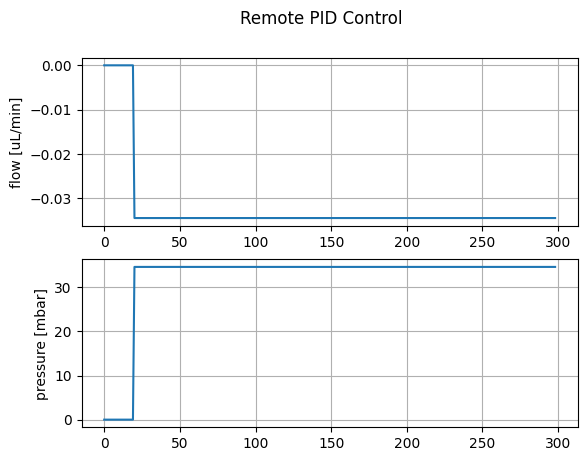

In [9]:
period = 0.1 # 10Hz

# Controller parameters: Very soft controller
K_p = 0.5 # <- Change this value to tune the controller
K_i = 0.01 # <- Change this value too to tune the controller
ref_flow = 40 # uL/min

p_min = 0 # <- This is only negative if you have some vacuum source
p_max = 1000 # <- This depends on the Z regulator of each channel
I_min = 0 
I_max = 1

experiment_t = 30

# OB1 arrangement
p_channel = 1 # <- Change this to
fs_channel = 1 # <- your real configuration

# Start running the PI Control on remote mode
error = OB1_Start_Remote_Measurement(Instr_ID.value, byref(Calib), 1000)
print(error)
# Start the PID Controller onsite
p_channel = c_int32( int(p_channel) ) # convert to c_int32
fs_channel = c_int32( int(fs_channel) ) # convert to c_int32
error = PID_Add_Remote(Instr_ID.value, p_channel, Instr_ID.value, fs_channel, K_p, K_i, 1) 
print(error)
# Set the reference
ref_flow = c_double( float(ref_flow) )
error = OB1_Set_Remote_Target(Instr_ID.value, p_channel, ref_flow) 
print(error)


flow_list = []
control_list = []
meas_flow = c_double()
control_val = c_double()

start_t = time.time() # <- This must be close to the routine
last_t = start_t
while True:
    error = OB1_Get_Remote_Data(Instr_ID.value, fs_channel, byref(control_val), byref(meas_flow))
    print(error)
    flow_list.append( meas_flow.value )
    control_list.append( control_val.value )

    # Check if the elapsed time match the time limit
    if (time.time() - start_t) > experiment_t:
        break
    # Wait until desired period time
    sleep_t = period - (time.time() - last_t)
    if sleep_t > 0:
        time.sleep( sleep_t )
    last_t = time.time() # And update the last time

    print(meas_flow.value, control_val.value)


error = OB1_Stop_Remote_Measurement(Instr_ID.value)
print('Stop. Error value: %d' % error)

# Plot the signals
plt.rcParams['axes.grid'] = True
fig=plt.figure()
fig.suptitle("Remote PID Control")

plt.subplot(2,1,1)
plt.plot( flow_list )
plt.ylabel('flow [uL/min]')
plt.subplot(2,1,2)
plt.plot( control_list )
plt.ylabel('pressure [mbar]')